In [4]:
import numpy as np
import os
import struct

def load_emnist_images(file_path):
    with open(file_path, 'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    return images

def load_emnist_labels(file_path):
    with open(file_path, 'rb') as f:
        magic, num = struct.unpack('>II', f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels


In [4]:
import numpy as np
import os
import struct

def load_emnist_images(file_path):
    with open(file_path, 'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    return images

def load_emnist_labels(file_path):
    with open(file_path, 'rb') as f:
        magic, num = struct.unpack('>II', f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels


In [5]:
base_path = 'D:/mnist_model/emnist_source_files'

# Load balanced split
train_images = load_emnist_images(os.path.join(base_path, 'emnist-balanced-train-images-idx3-ubyte'))
train_labels = load_emnist_labels(os.path.join(base_path, 'emnist-balanced-train-labels-idx1-ubyte'))

test_images = load_emnist_images(os.path.join(base_path, 'emnist-balanced-test-images-idx3-ubyte'))
test_labels = load_emnist_labels(os.path.join(base_path, 'emnist-balanced-test-labels-idx1-ubyte'))

# Shape check
print("Train images:", train_images.shape)
print("Train labels:", train_labels.shape)


Train images: (112800, 28, 28)
Train labels: (112800,)


In [6]:
import matplotlib.pyplot as plt

# Rotate each image by 90 deg CCW and flip vertically
def preprocess_emnist(images):
    images = np.transpose(images, (0, 2, 1))  # Transpose
    images = np.flip(images, axis=2)         # Horizontal flip
    return images / 255.0                    # Normalize

train_images = preprocess_emnist(train_images)
test_images = preprocess_emnist(test_images)

# Expand channel dimension
train_images = np.expand_dims(train_images, -1)
test_images = np.expand_dims(test_images, -1)


In [7]:
# Load label mapping: EMNIST class -> ASCII code
mapping_file = os.path.join(base_path, '..', 'emnist-balanced-mapping.txt')
mapping = np.loadtxt(mapping_file, dtype=int)

# Create dictionary: label_index -> character
label_to_char = {idx: chr(ascii_code) for idx, ascii_code in mapping}

# Example: print a few characters
for i in range(10):
    print(f"Label {train_labels[i]} -> Character: {label_to_char[train_labels[i]]}")


Label 45 -> Character: r
Label 36 -> Character: a
Label 43 -> Character: n
Label 15 -> Character: F
Label 4 -> Character: 4
Label 42 -> Character: h
Label 26 -> Character: Q
Label 32 -> Character: W
Label 20 -> Character: K
Label 1 -> Character: 1


In [8]:
def augment_with_mirrored_data(images, labels):
    flipped_images = np.flip(images, axis=2)  # Horizontal flip
    all_images = np.concatenate([images, flipped_images], axis=0)
    all_labels = np.concatenate([labels, labels], axis=0)
    
    is_flipped = np.array([0] * len(images) + [1] * len(flipped_images))
    return all_images, all_labels, is_flipped

aug_train_images, aug_train_labels, train_is_flipped = augment_with_mirrored_data(train_images, train_labels)
aug_test_images, aug_test_labels, test_is_flipped = augment_with_mirrored_data(test_images, test_labels)


In [9]:
import tensorflow as tf

num_classes = len(np.unique(train_labels))

def create_tf_dataset(images, labels, flip_flags, batch_size=128):
    labels_cat = tf.keras.utils.to_categorical(labels, num_classes)
    flip_flags = np.array(flip_flags).astype(np.float32).reshape(-1, 1)
    full_labels = np.concatenate([labels_cat, flip_flags], axis=1)
    
    dataset = tf.data.Dataset.from_tensor_slices((images.astype(np.float32), full_labels))
    return dataset.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = create_tf_dataset(aug_train_images, aug_train_labels, train_is_flipped)
test_ds = create_tf_dataset(aug_test_images, aug_test_labels, test_is_flipped)


In [10]:
from tensorflow.keras import layers, models

input_shape = train_images.shape[1:]

inputs = tf.keras.Input(shape=input_shape)

x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)

# Dual outputs
char_output = layers.Dense(num_classes, activation='softmax', name='char_output')(x)
flip_output = layers.Dense(1, activation='sigmoid', name='flip_output')(x)

model = models.Model(inputs=inputs, outputs=[char_output, flip_output])

model.compile(
    optimizer='adam',
    loss={
        'char_output': 'categorical_crossentropy',
        'flip_output': 'binary_crossentropy'
    },
    metrics={
        'char_output': 'accuracy',
        'flip_output': 'accuracy'
    }
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 28, 28, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 26, 26, 32)        │             320 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 13, 13, 32)        │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 11, 11, 64)        │          18,496 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 5, 5, 64)          │               0 │ conv2d_1[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 1600)              │               0 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │         204,928 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ char_output (Dense)           │ (None, 47)                │           6,063 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flip_output (Dense)           │ (None, 1)                 │             129 │ dense[0][0]                │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 229,936 (898.19 KB)

 Trainable params: 229,936 (898.19 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
train_labels_cat = tf.keras.utils.to_categorical(aug_train_labels, num_classes)
test_labels_cat = tf.keras.utils.to_categorical(aug_test_labels, num_classes)

history = model.fit(
    x=aug_train_images,
    y={
        'char_output': train_labels_cat,
        'flip_output': train_is_flipped
    },
    validation_data=(
        aug_test_images,
        {
            'char_output': test_labels_cat,
            'flip_output': test_is_flipped
        }
    ),
    epochs=10,
    batch_size=128
)


Epoch 1/10
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 135s 74ms/step - char_output_accuracy: 0.5925 - char_output_loss: 1.4173 - flip_output_accuracy: 0.8361 - flip_output_loss: 0.3664 - loss: 1.7837 - val_char_output_accuracy: 0.7938 - val_char_output_loss: 0.6281 - val_flip_output_accuracy: 0.9027 - val_flip_output_loss: 0.2356 - val_loss: 0.8637
Epoch 2/10
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 153s 80ms/step - char_output_accuracy: 0.8139 - char_output_loss: 0.5577 - flip_output_accuracy: 0.9071 - flip_output_loss: 0.2267 - loss: 0.7844 - val_char_output_accuracy: 0.8241 - val_char_output_loss: 0.5245 - val_flip_output_accuracy: 0.9159 - val_flip_output_loss: 0.2030 - val_loss: 0.7276
Epoch 3/10
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 129s 73ms/step - char_output_accuracy: 0.8418 - char_output_loss: 0.4638 - flip_output_accuracy: 0.9201 - flip_output_loss: 0.1966 - loss: 0.6605 - val_char_output_accuracy: 0.8329 - val_char_output_loss: 0.4924 - val_flip_output_accuracy: 0.9195 - val_flip_output_loss: 0.1933 - 

In [13]:
import matplotlib.pyplot as plt

def show_predictions(model, images, labels, flip_flags, num=10):
    preds = model.predict(images[:num])
    pred_classes = np.argmax(preds[0], axis=1)
    pred_flip = (preds[1] > 0.5).astype(int).flatten()

    for i in range(num):
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"True: {label_to_char[labels[i]]}, Pred: {label_to_char[pred_classes[i]]} | Flip: {flip_flags[i]} -> {pred_flip[i]}")
        plt.axis('off')
        plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


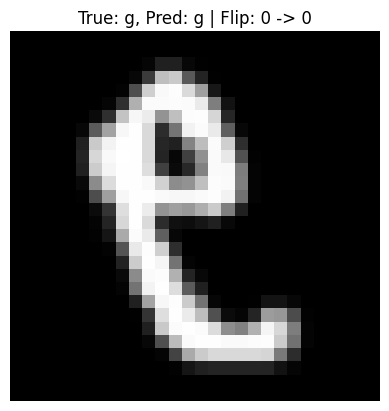

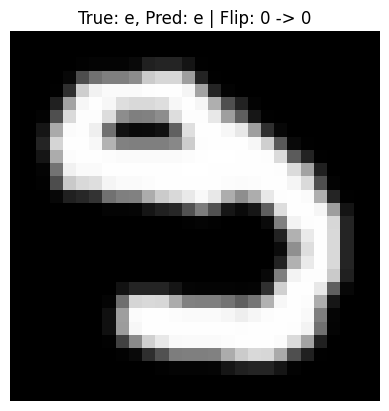

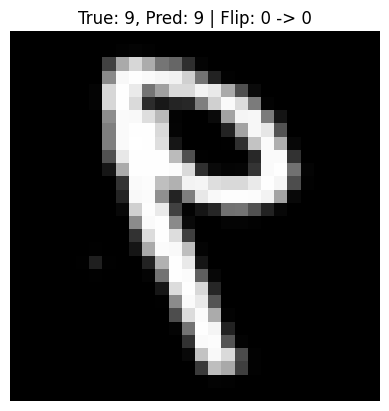

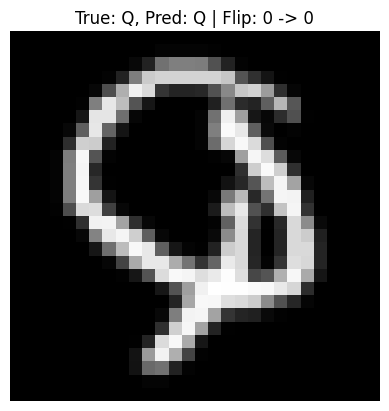

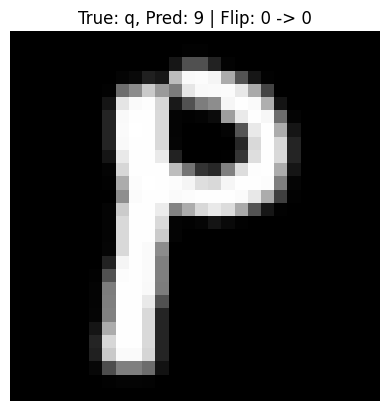

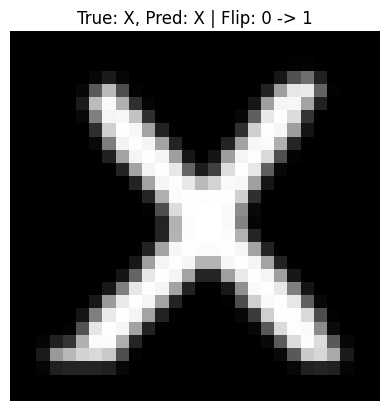

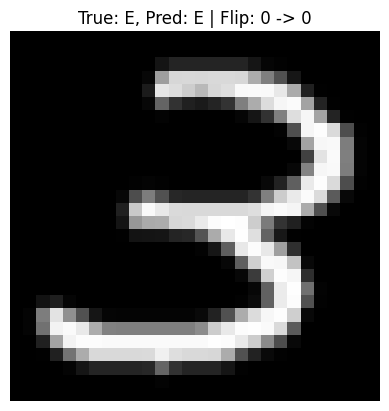

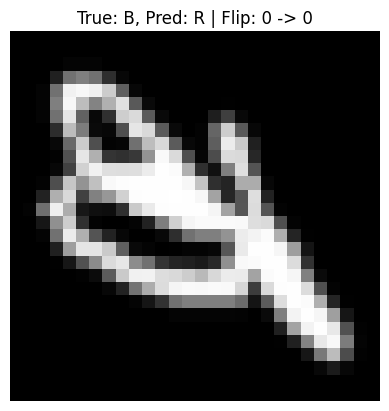

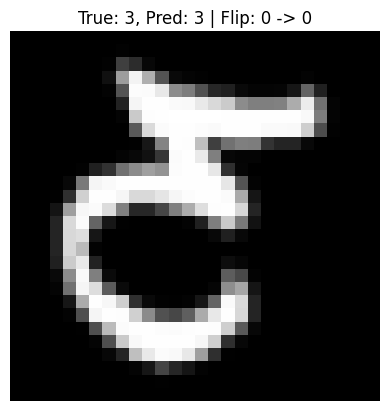

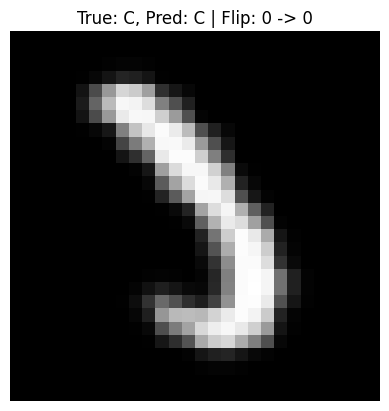

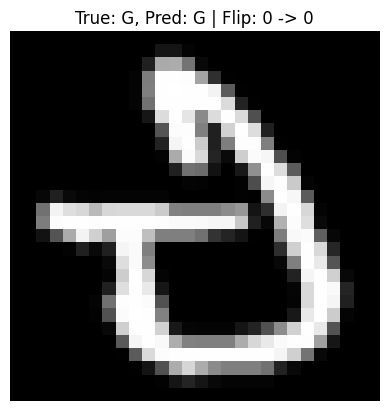

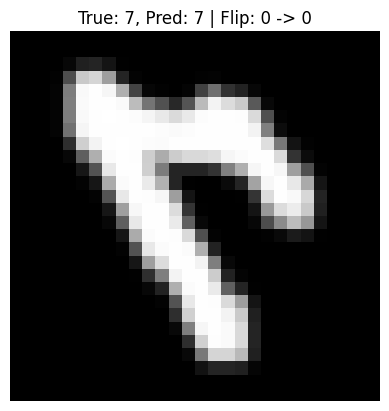

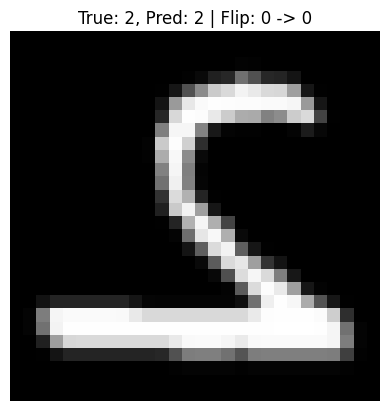

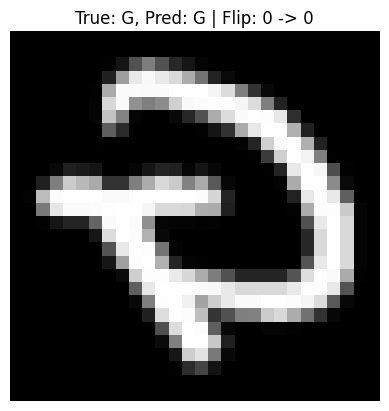

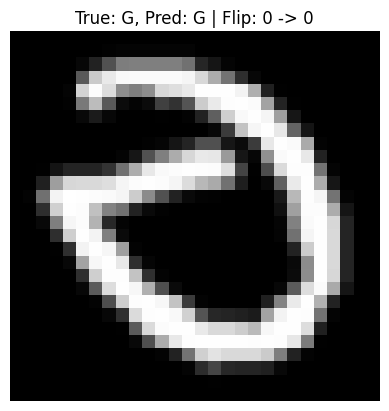

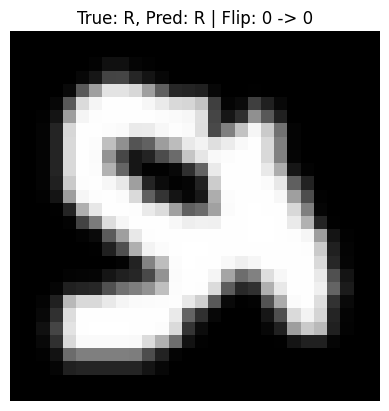

In [17]:
show_predictions(model, aug_test_images, aug_test_labels, test_is_flipped, num=16)


In [18]:
print("Flip flags in batch:", np.unique(test_is_flipped, return_counts=True))


Flip flags in batch: (array([0, 1]), array([18800, 18800]))
